An example of the necissity/utility of a ordered cross validation plan (especially for time-oriented data).




In [1]:
import functools
import operator
import pygam
import pandas
import math
import numpy
import seaborn
import matplotlib
import matplotlib.pyplot
import sklearn
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline
import vtreat
import vtreat.cross_plan


Make an example

In [2]:
numpy.random.seed(seed=2018)

def mk_example(minv, maxv, step):
    d = pandas.DataFrame({'x': numpy.arange(minv, maxv, step)})
    d['y_theoretical'] = [math.sin(1.1*x) for x in d['x']]
    return(d)
    
d = mk_example(0, 15, 0.2)
d['y'] = d['y_theoretical'] + 0.2*numpy.random.normal(0,1,len(d['y_theoretical']))
d['train'] = numpy.random.uniform(0,1,len(d['y_theoretical']))>=0.5

dtrain = d[d['train']].copy()
dtrain.reset_index(inplace=True, drop=True)
dexpanded = mk_example(-5, 20, 0.1)
d.head()

,x,y_theoretical,y,train
0,0.0,0.000000,-0.055354,False
1,0.2,0.218230,0.334600,False
2,0.4,0.425939,0.855619,False
3,0.6,0.613117,0.357219,False
4,0.8,0.770739,0.871194,True


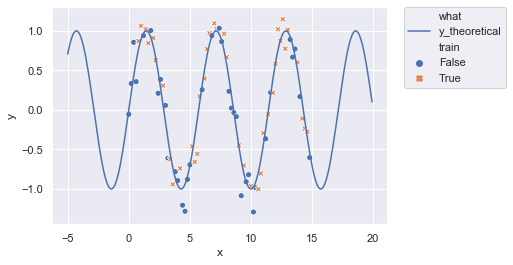

In [3]:
def plotf(dpts, dcurves, curves):
    seaborn.set(style="darkgrid")
    pd = dcurves.loc[:, ["x"] + curves]
    pd = pd.set_index("x")
    pd = pandas.DataFrame.unstack(pd)
    pd = pd.reset_index()
    pd = pd.rename(columns={"level_0": "what", "x": "x", 0:"y"})
    matplotlib.pyplot.clf()
    seaborn.lineplot(x="x", y="y", hue="what", data=pd)
    seaborn.scatterplot(x="x", y="y", hue="train", style="train", data=dpts)
    matplotlib.pyplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    matplotlib.pyplot.show()
    
plotf(d, dexpanded, ["y_theoretical"])

Use GAM to fit a model

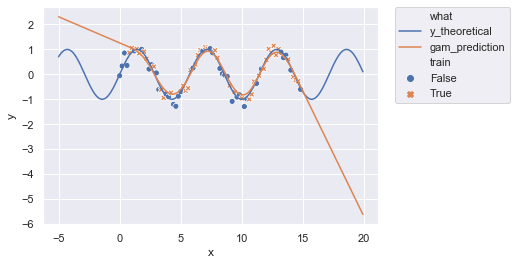

In [4]:
model = pygam.LinearGAM().fit(dtrain[['x']], dtrain['y'])

dexpanded['gam_prediction'] = model.predict(dexpanded[['x']])

plotf(d, dexpanded, ["y_theoretical", "gam_prediction"])

Use a basis of periodic functions

In [5]:
vars = []
for freq in [0.1, 0.25, 0.5, 1.0, 2.0, 4, 10]:
    for phase in [freq*offset for offset in [-1, -0.5, -0.25, 0, 0.25, 0.5, 1]]:
        vi = "sin((x+" + str(phase) + ")*" + str(freq) + ")"
        dexpanded[vi] = [ math.sin((x+phase)*freq) for x in dexpanded["x"] ]
        dtrain[vi] = [ math.sin((x+phase)*freq) for x in dtrain["x"] ]
        vars = vars + [vi]

dtrain.head()

,x,y_theoretical,y,train,sin((x+-0.1)*0.1),sin((x+-0.05)*0.1),sin((x+-0.025)*0.1),sin((x+0.0)*0.1),sin((x+0.025)*0.1),sin((x+0.05)*0.1),...,sin((x+1.0)*4),sin((x+2.0)*4),sin((x+4)*4),sin((x+-10)*10),sin((x+-5.0)*10),sin((x+-2.5)*10),sin((x+0)*10),sin((x+2.5)*10),sin((x+5.0)*10),sin((x+10)*10)
0,0.8,0.770739,0.871194,True,0.069943,0.074930,0.077422,0.079915,0.082406,0.084898,...,0.793668,-0.979178,0.343315,0.779466,0.916522,0.961397,0.989358,0.999912,0.992873,0.926819
1,1.0,0.891207,1.062413,True,0.089879,0.094857,0.097346,0.099833,0.102321,0.104807,...,0.989358,-0.536573,0.912945,-0.893997,-0.745113,-0.650288,-0.544021,-0.428183,-0.304811,-0.044243
2,1.4,0.999526,1.021542,True,0.129634,0.134590,0.137067,0.139543,0.142018,0.144492,...,-0.174327,0.859162,0.381250,0.923458,0.991779,0.999990,0.990607,0.963795,0.920026,0.784980
3,1.6,0.982154,0.844541,True,0.149438,0.154380,0.156850,0.159318,0.161786,0.164252,...,-0.827826,0.965658,-0.397556,-0.733190,-0.529083,-0.412118,-0.287903,-0.158623,-0.026551,0.236661
4,2.0,0.808496,0.910541,True,0.188859,0.193767,0.196219,0.198669,0.201119,0.203567,...,-0.536573,-0.287903,-0.905578,0.993889,0.988032,0.958924,0.912945,0.850904,0.773891,0.580611


Work with a standard random k-way cross validation plan.

We will search this grid.

In [6]:
alphas = [ 10 ** k for k in range(-3, 3, 1) ]
l1_ratios = numpy.arange(0, 1, 0.1)
grid = [ [ {"alpha": alpha, "l1_ratio": l1_ratio} for alpha in alphas ] for l1_ratio in l1_ratios ]
grid = functools.reduce(operator.concat, grid)
grid[0]

{'alpha': 0.001, 'l1_ratio': 0.0}

In [7]:
def cross_predict_model(fitter, X, Y, plan):
    preds = numpy.zeros(X.shape[0])
    for g in range(len(plan)):
        pi = plan[g]
        model = fitter.fit(X.iloc[pi["train"]], Y.iloc[pi["train"]])
        predg = model.predict(X.iloc[pi["app"]])
        preds[pi["app"]] = predg
    return preds

def est_quality(settings, plan):
    fitter = sklearn.linear_model.ElasticNet(alpha = settings["alpha"], 
                                             l1_ratio = settings["l1_ratio"], fit_intercept=True)
    preds = cross_predict_model(fitter, dtrain[vars], dtrain['y'], plan)
    mean_sq_error = numpy.mean((dtrain['y'] - preds)**2)
    return mean_sq_error

In [8]:
%%capture
k_way_plan = vtreat.cross_plan.k_way_cross_plan(n_rows=dtrain.shape[0], k_folds=5)
param_evals = [ {"settings" : settings, "loss" : est_quality(settings, k_way_plan)} for settings in grid ]

In [9]:
min_loss = numpy.min([ q["loss"] for q in param_evals ])
best_params = [ q for q in param_evals if q["loss"] <= min_loss + 1e-9 ]
best_params

[{'settings': {'alpha': 0.001, 'l1_ratio': 0.0}, 'loss': 0.05927056861189515}]

/Users/johnmount/anaconda3/envs/aiAcademy/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7340904141036223, tolerance: 0.001997642400668087
  positive)


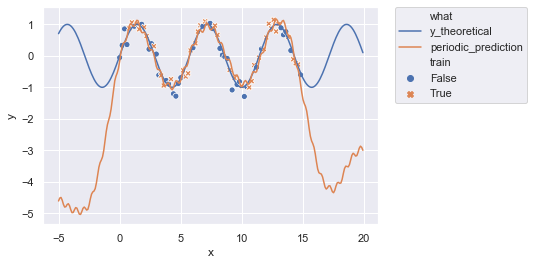

In [10]:
settings = best_params[0]["settings"]
fitter = sklearn.linear_model.ElasticNet(alpha = settings["alpha"], l1_ratio = settings["l1_ratio"], fit_intercept=True)
model = fitter.fit(dtrain[vars], dtrain['y'])
dexpanded['periodic_prediction'] = model.predict(dexpanded[vars])
plotf(d, dexpanded, ["y_theoretical", "periodic_prediction"])

Now the same process with an ordered cross-validation plan.

In [11]:
%%capture
ordered_plan = vtreat.cross_plan.order_cross_plan(k_folds=5, order_vector=dtrain['x'])
param_evals = [ {"settings" : settings, "loss" : est_quality(settings, ordered_plan)} for settings in grid ]

In [12]:
min_loss = numpy.min([ q["loss"] for q in param_evals ])
best_params = [ q for q in param_evals if q["loss"] <= min_loss + 1e-9 ]
best_params


[{'settings': {'alpha': 0.1, 'l1_ratio': 0.9}, 'loss': 0.2554900300865486}]

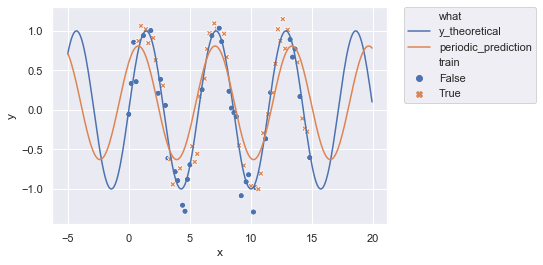

In [13]:
settings = best_params[0]["settings"]
fitter = sklearn.linear_model.ElasticNet(alpha = settings["alpha"], l1_ratio = settings["l1_ratio"], fit_intercept=True)
model = fitter.fit(dtrain[vars], dtrain['y'])
dexpanded['periodic_prediction'] = model.predict(dexpanded[vars])
plotf(d, dexpanded, ["y_theoretical", "periodic_prediction"])

Notice how the model, calibrated and trained only on the training subset of the training interval is somewhat close to all training
and hold out data *and* a plausible shape outside of the training region!  We got a plausible extrapolation (which is asking a lot).